2025-05-23 03:30:11,154 - __main__ - INFO - Running model prediction
2025-05-23 03:30:11,412 - __main__ - INFO - Detected boundary frames: [33, 185]
2025-05-23 03:30:11,419 - __main__ - WARNING - Could not determine label for ./data/kinect_good_vs_bad_not_preprocessed\A1.csv (A1.csv), skipping
2025-05-23 03:30:11,610 - __main__ - INFO - Running model prediction
2025-05-23 03:30:11,928 - __main__ - INFO - Detected boundary frames: [59, 167]
2025-05-23 03:30:12,171 - __main__ - INFO - Running model prediction
2025-05-23 03:30:12,446 - __main__ - INFO - Detected boundary frames: [83, 248]
2025-05-23 03:30:12,657 - __main__ - INFO - Running model prediction
2025-05-23 03:30:12,940 - __main__ - INFO - Detected boundary frames: [13, 183]
2025-05-23 03:30:13,184 - __main__ - INFO - Running model prediction
2025-05-23 03:30:13,446 - __main__ - INFO - Detected boundary frames: [64, 165]
2025-05-23 03:30:13,667 - __main__ - INFO - Running model prediction
2025-05-23 03:30:14,385 - __main__ - INF

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10)             │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,011 (7.86 KB)

 Trainable params: 2,011 (7.86 KB)

 Non-trainable params: 0 (0.00 B)

Fold 1/10


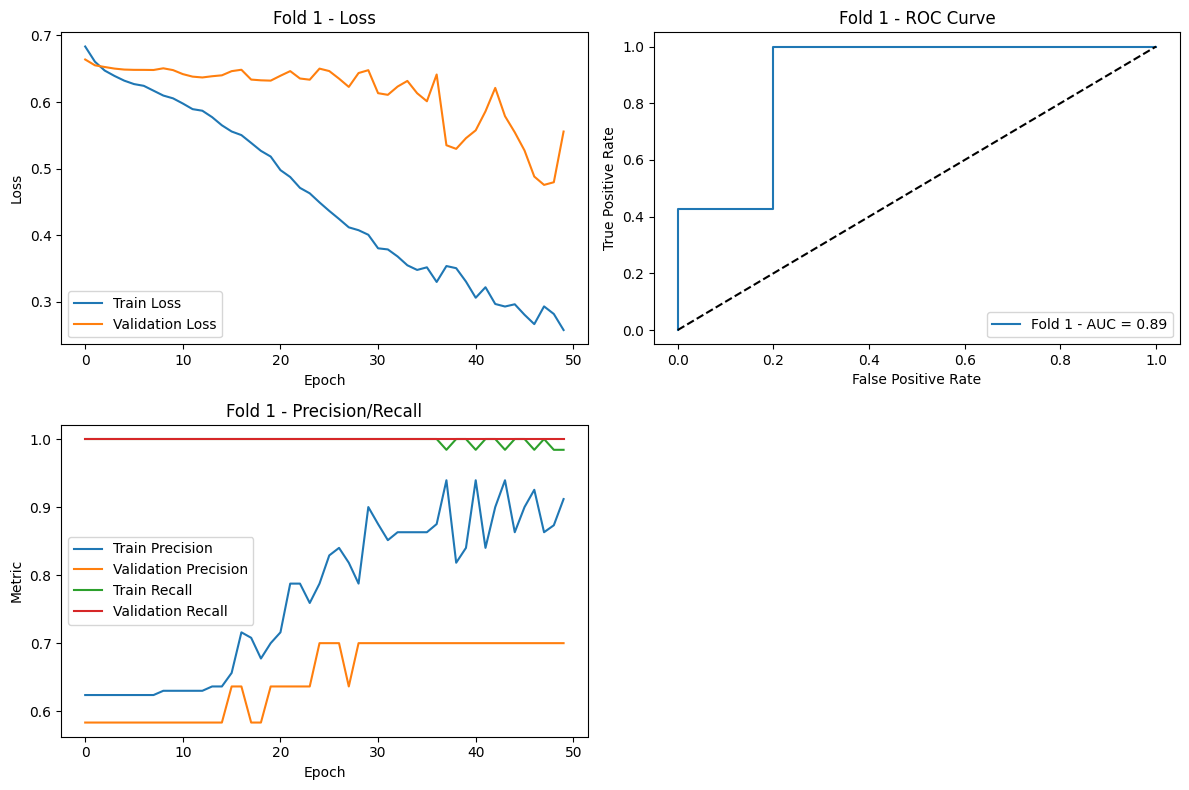

Fold 2/10


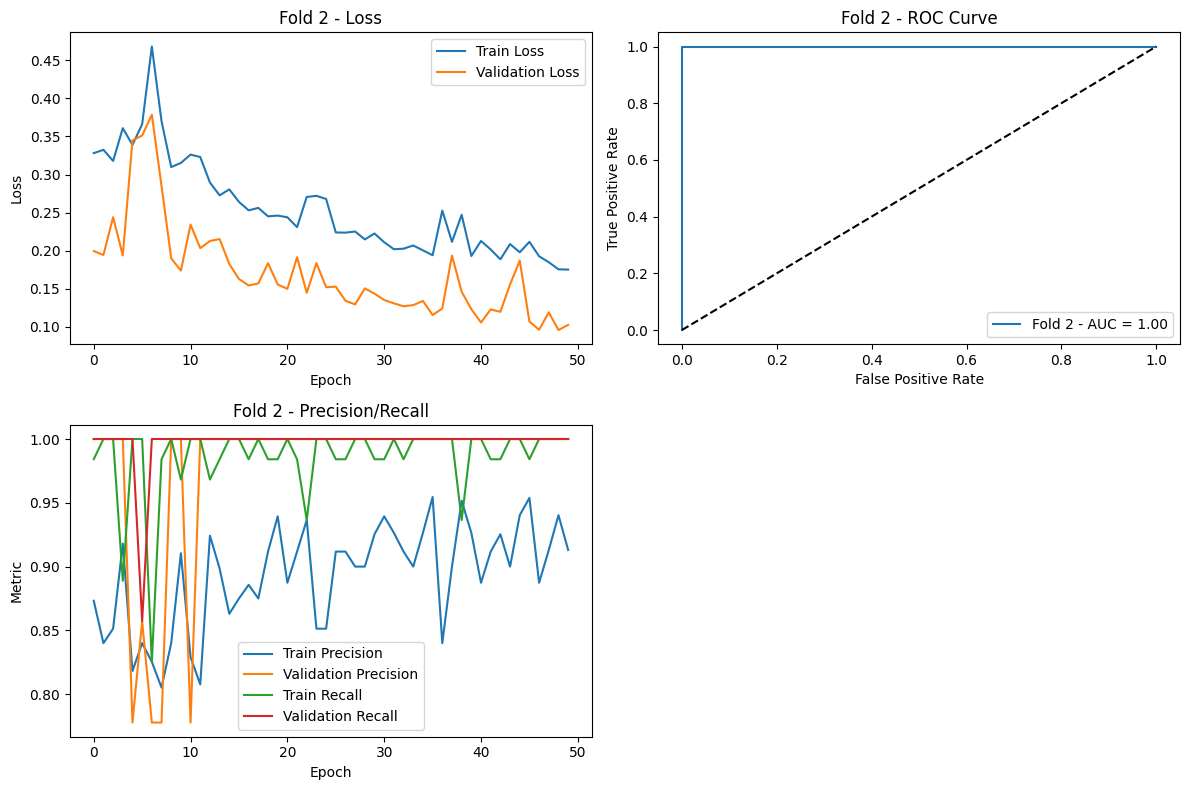

Fold 3/10


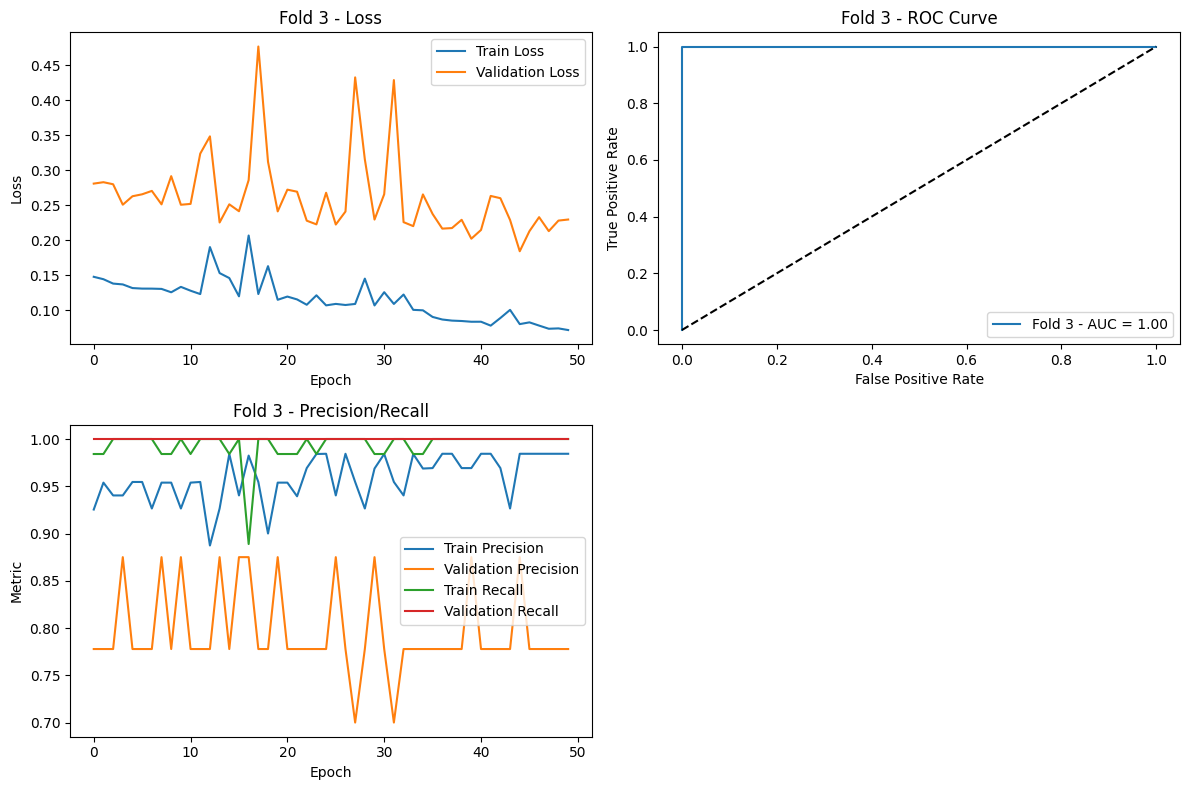

Fold 4/10


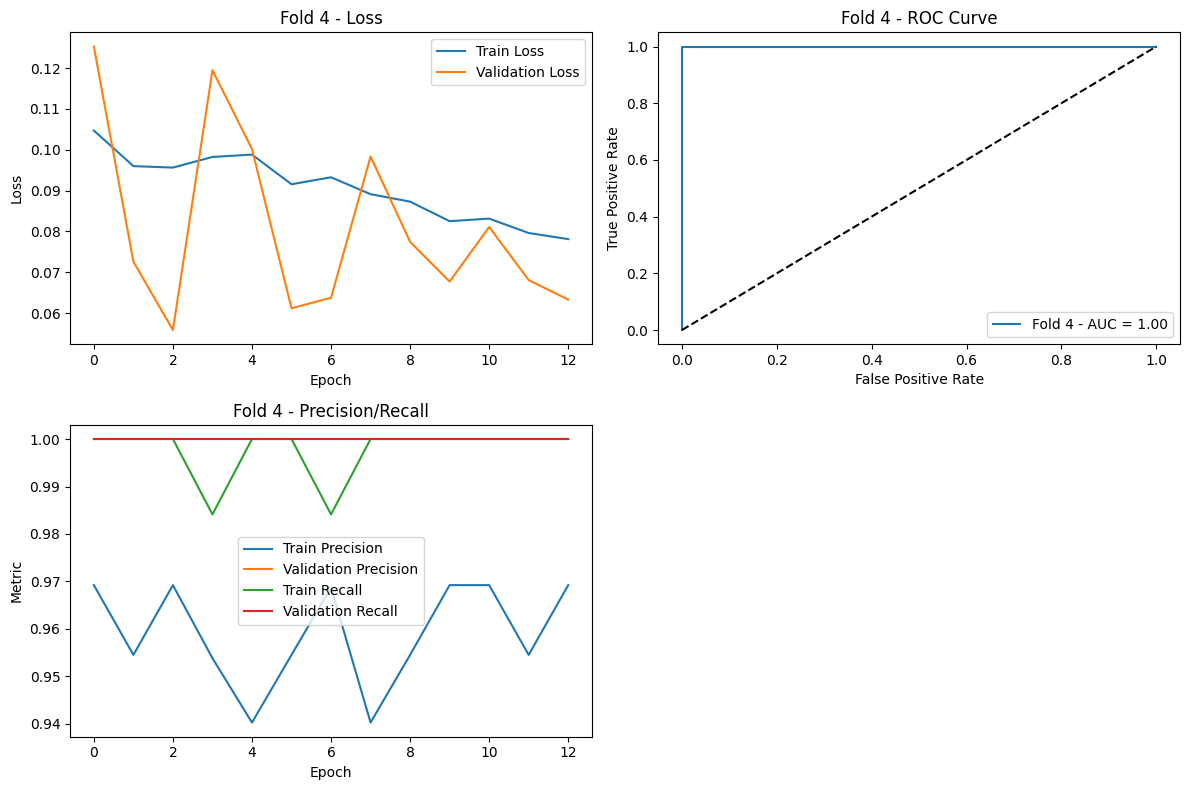

Fold 5/10


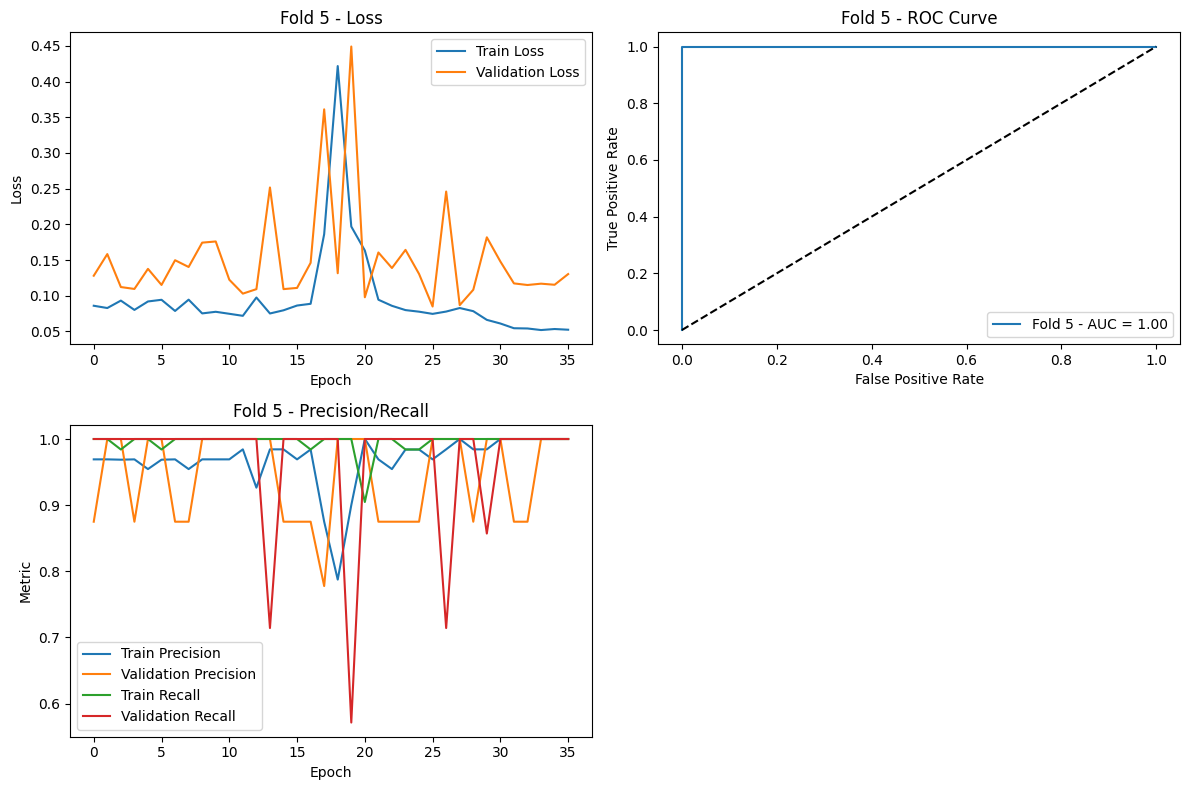

Fold 6/10


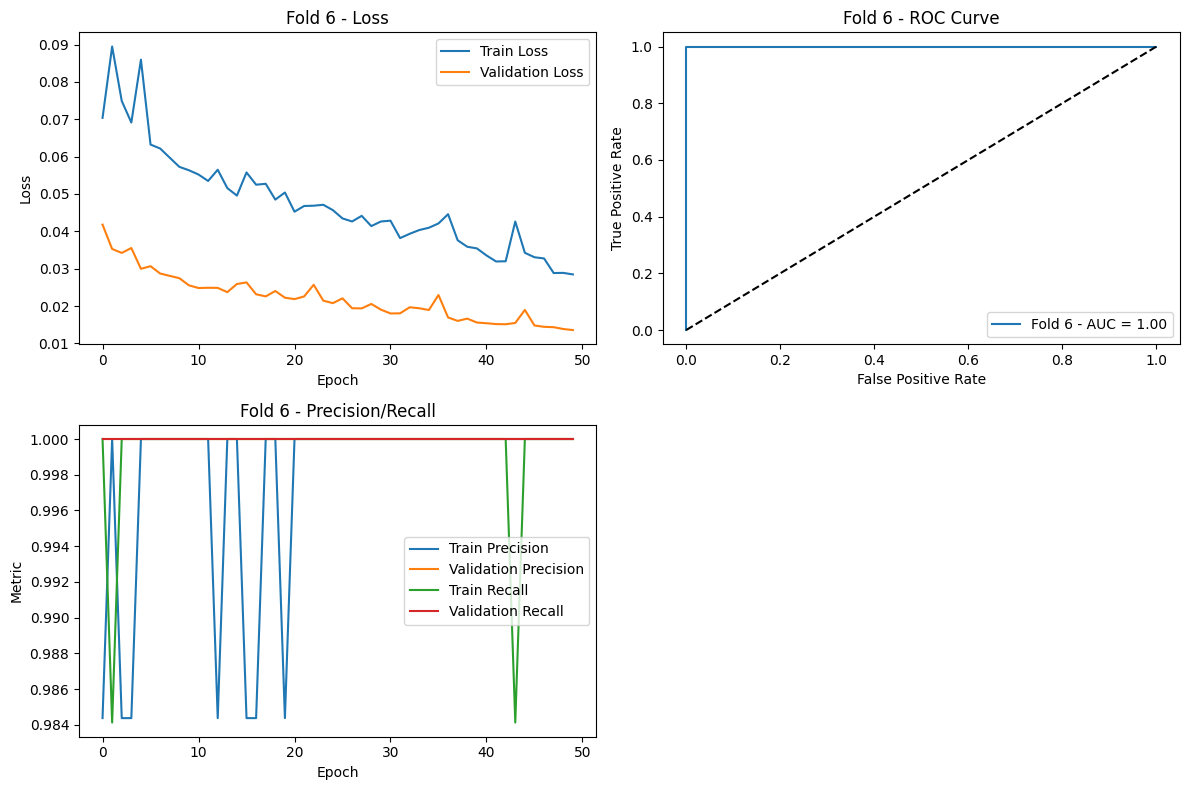

Fold 7/10


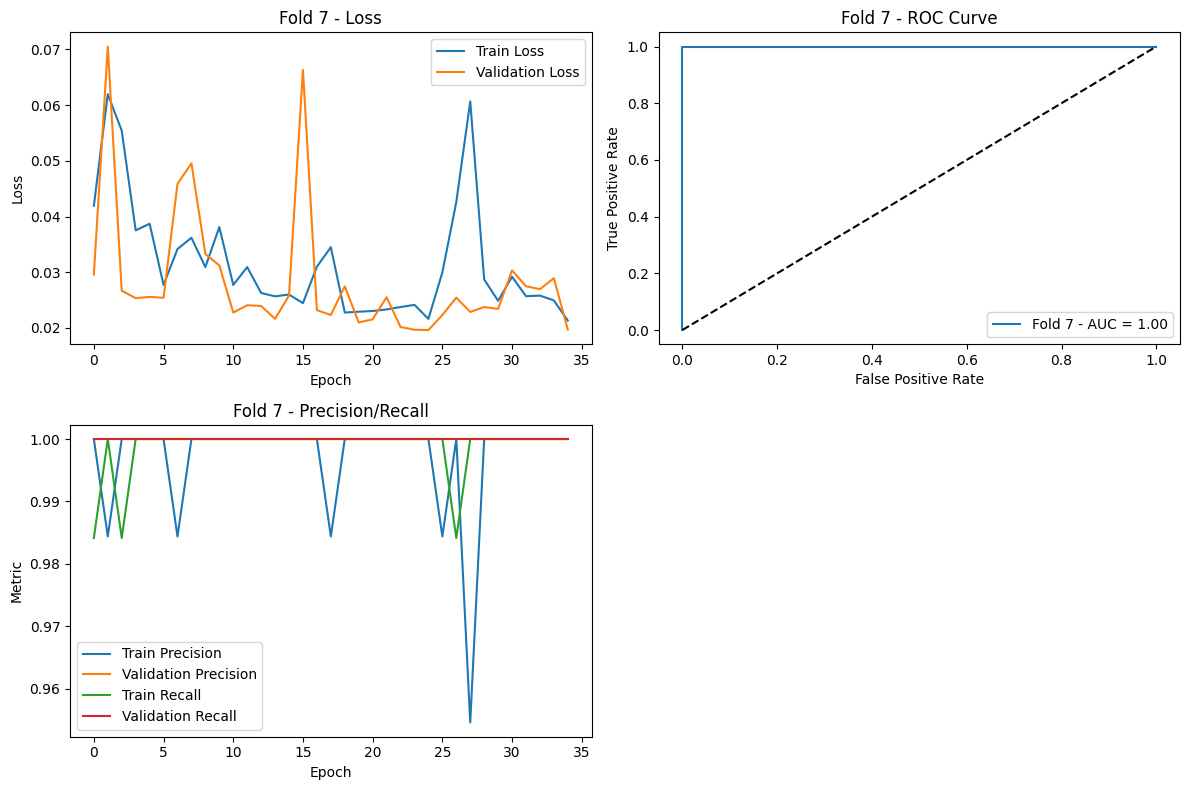

Fold 8/10


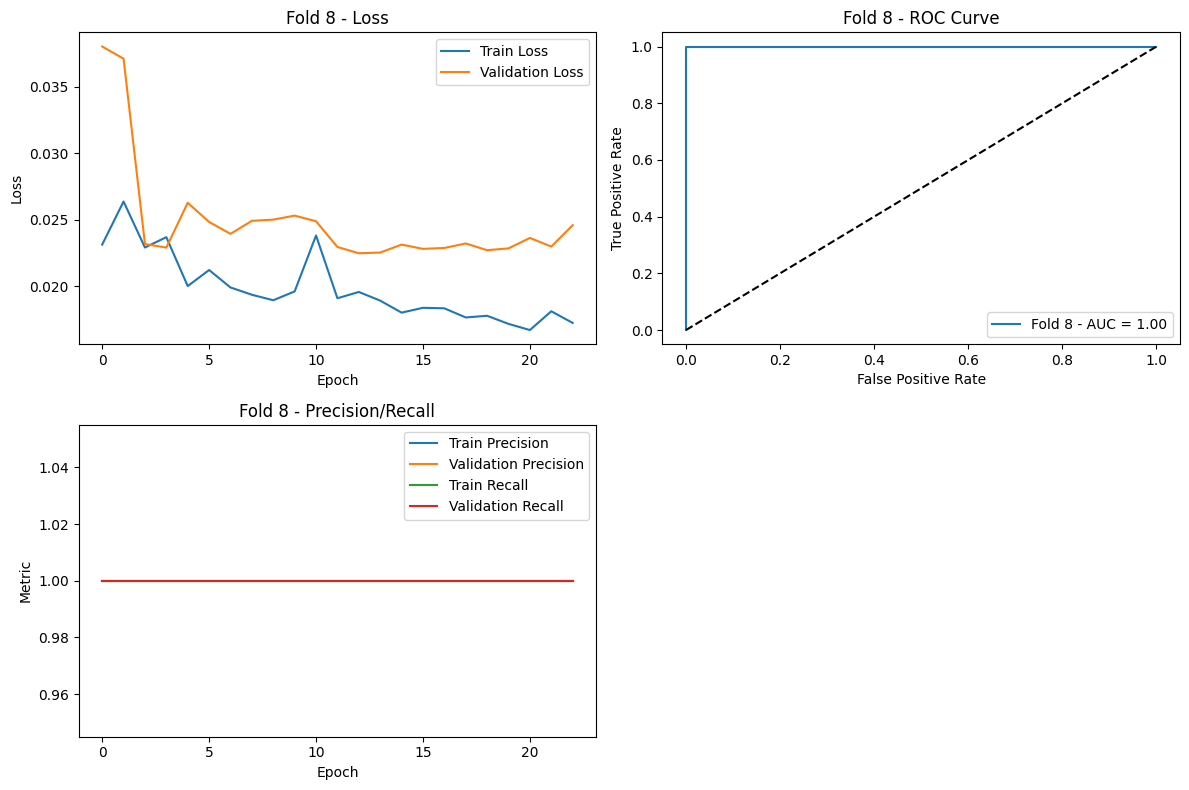

Fold 9/10


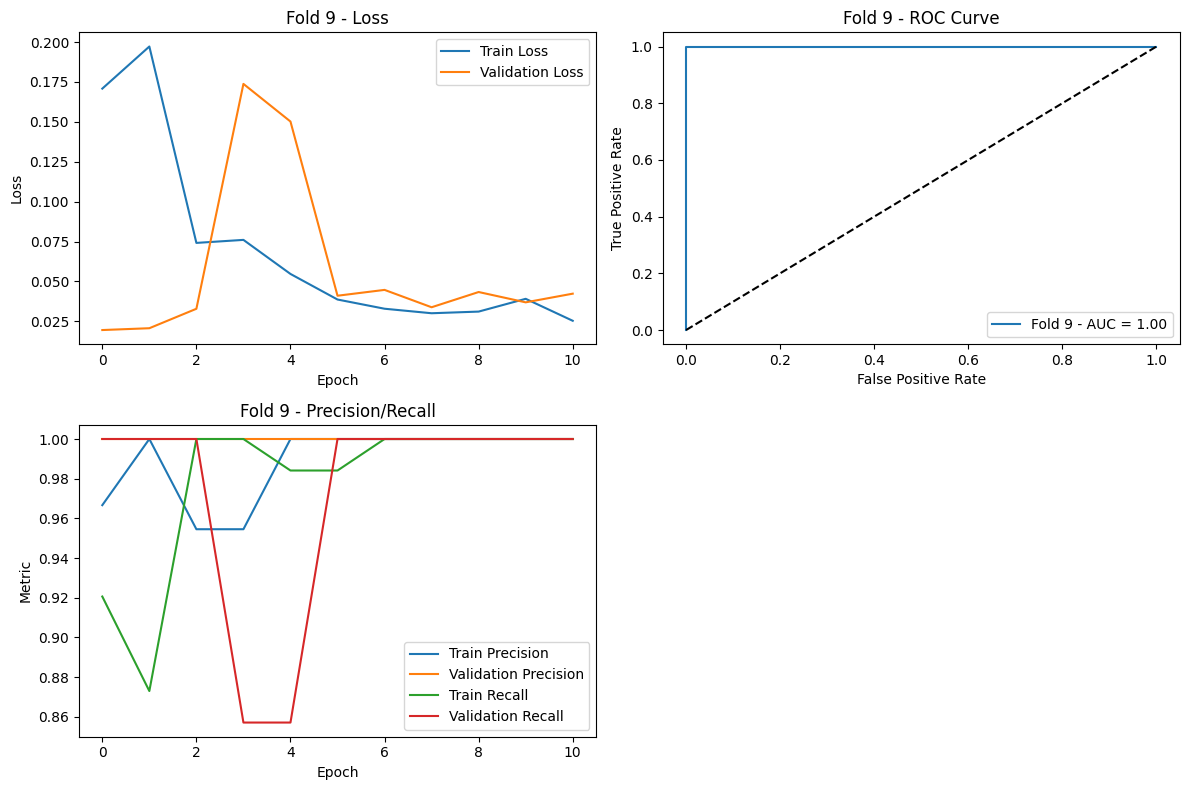

Fold 10/10


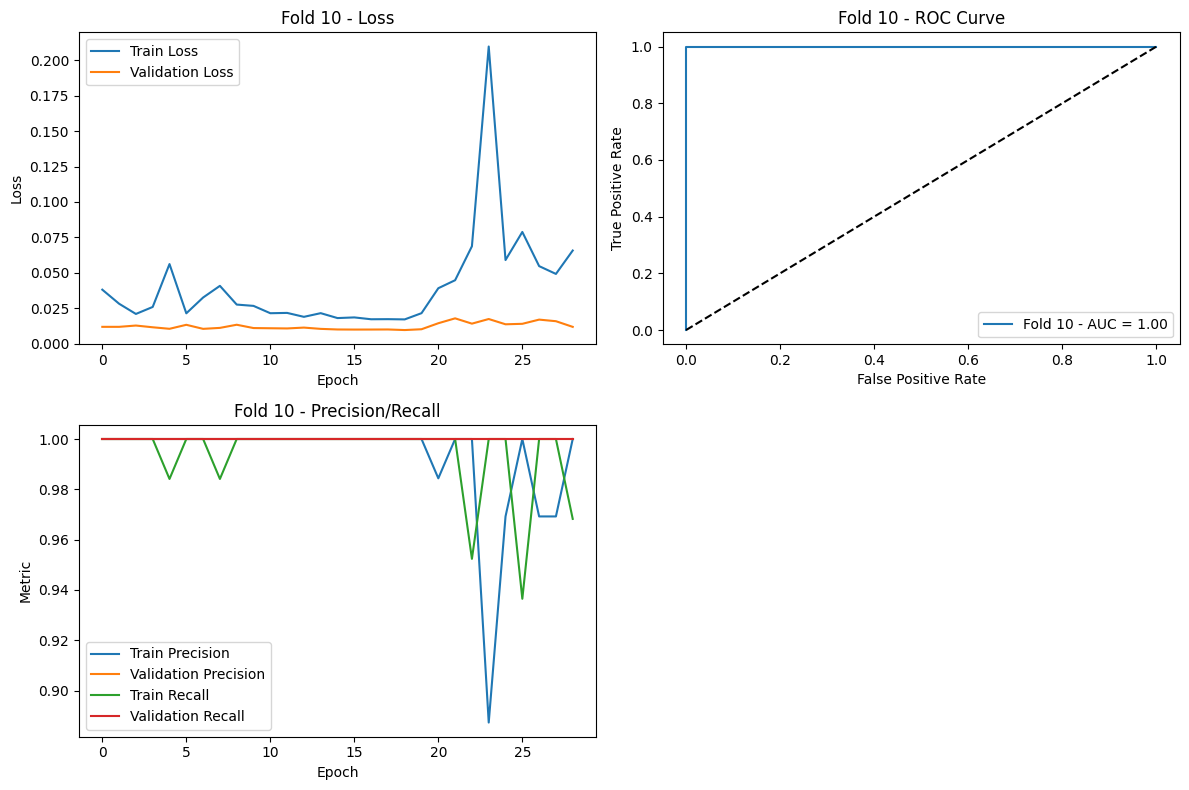

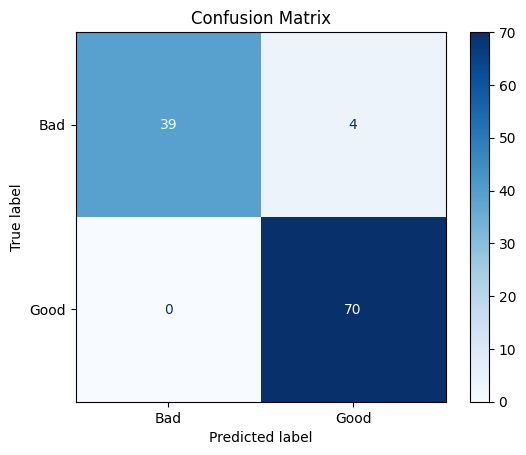


--- Overall Metrics ---
Overall Precision: 0.9459
Overall Recall: 1.0000
Overall F1-score: 0.9722
Overall AUC: 0.9535

Retraining model on the full dataset...
Full-dataset training complete.
Retrained model and scaler saved successfully!

--- Misclassified Videos ---
- W07_trimmed.csv
- W18_trimmed.csv
- W30_trimmed.csv
- W24_trimmed.csv


In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import logging
from pathlib import Path
from joblib import load, dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
)
from tensorflow.python.keras.layers import Conv3D

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


def trim_frames(input_csv, output_csv=None, model_dir="models"):
    """
    Trim a sequence using the trained model to identify the
    relevant segment of motion data.
    """
    try:
        if output_csv is None:
            input_path = Path(input_csv)
            output_dir = input_path.parent / "trimmed_output"
            output_dir.mkdir(exist_ok=True)
            output_csv = output_dir / f"{input_path.stem}_trimmed.csv"

        model_path = Path(model_dir) / "kinect_cutting_model.keras"
        scaler_path = Path(model_dir) / "kinect_cutting_scaler.pkl"

        if not model_path.exists() or not scaler_path.exists():
            logger.warning(f"Cutting model not found in {model_dir}")
            df = pd.read_csv(input_csv)
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)

        #logger.info(f"Trimming frames in {input_csv} using {model_path.name}")

        df = pd.read_csv(input_csv)
        #logger.info(f"Loaded {input_csv}: {len(df)} frames")

        if len(df) < 11:
            logger.warning(f"Too few frames ({len(df)}) for trimming, minimum is 11")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)

        model = tf.keras.models.load_model(model_path)
        scaler = load(scaler_path)

        X = df.drop(columns=["FrameNo"], errors='ignore') if "FrameNo" in df.columns else df.copy()

        X.columns = X.columns.str.strip()

        WINDOW = 11
        HALF = WINDOW // 2
        n_frames = len(X)

        win_feats, centres = [], []
        for idx in range(HALF, n_frames - HALF):
            window = X.iloc[idx - HALF: idx + HALF + 1]
            if window.shape[0] != WINDOW:
                logger.warning(f"Inconsistent window shape at index {idx}: {window.shape}")
                continue
            win_feats.append(window.values.ravel())
            centres.append(idx)

        if not win_feats:
            logger.warning("No valid windows could be created")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, n_frames - 1)

        X_win = np.stack(win_feats)
        #logger.info(f"Shape of X_win before scaling: {X_win.shape}")

        X_win = scaler.transform(X_win)
        #logger.info(f"Shape of X_win before prediction: {X_win.shape}")

        logger.info("Running model prediction")
        pred_prob = model.predict(X_win, verbose=0).ravel()
        pred_lbl = (pred_prob >= 0.5).astype(int)

        frame_pred = np.zeros(n_frames, dtype=int)
        for c_idx, lbl in zip(centres, pred_lbl):
            frame_pred[c_idx] = lbl

        for i in range(1, n_frames - 1):
            if frame_pred[i - 1] == frame_pred[i + 1] != frame_pred[i]:
                frame_pred[i] = frame_pred[i - 1]

        segments, in_seg = [], False
        for i, l in enumerate(frame_pred):
            if l == 1 and not in_seg:
                in_seg, seg_start = True, i
            if (l == 0 and in_seg) or (in_seg and i == n_frames - 1):
                seg_end = i - 1 if l == 0 else i
                segments.append((seg_start, seg_end))
                in_seg = False

        if not segments:
            logger.warning("No valid segments found, returning original sequence")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, n_frames - 1)

        seg_lens = [e - s + 1 for s, e in segments]
        idx_long = int(np.argmax(seg_lens))
        start_idx, end_idx = segments[idx_long]

        logger.info(f"Detected boundary frames: [{start_idx}, {end_idx}]")
        percent_kept = (end_idx - start_idx + 1) / n_frames * 100
        #logger.info(f"Keeping {end_idx - start_idx + 1} frames ({percent_kept:.1f}% of original)")

        trimmed_df = df.iloc[start_idx:end_idx + 1].copy()
        trimmed_df.to_csv(output_csv, index=False)
        #logger.info(f"Trimmed sequence saved to {output_csv}")

        return output_csv, (start_idx, end_idx)

    except Exception as e:
        logger.error(f"Error trimming frames: {e}")
        try:
            df = pd.read_csv(input_csv)
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)
        except:
            raise


def load_and_preprocess_data(data_dir, trimmed_data_dir, sequence_length):
    """Loads and preprocesses data, returning trimmed CSV paths, data, and labels."""

    file_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    os.makedirs(trimmed_data_dir, exist_ok=True)

    trimmed_csv_paths = []
    labels = []
    all_data = []

    for file_path in file_paths:
        input_path = Path(file_path)
        trimmed_output_csv = os.path.join(
            trimmed_data_dir, f"{input_path.stem}_trimmed.csv"
        )
        trimmed_csv_path, _ = trim_frames(file_path, trimmed_output_csv)

        if not os.path.exists(trimmed_csv_path):
            logger.error(
                f"Trimmed CSV was not created for {file_path}, using original file"
            )
            trimmed_csv_path = file_path

        trimmed_csv_paths.append(trimmed_csv_path)

        filename = os.path.basename(file_path)
        if filename.startswith("G"):
            labels.append(1)
        elif filename.startswith("W"):
            labels.append(0)
        else:
            logger.warning(
                f"Could not determine label for {file_path} ({filename}), skipping"
            )
            trimmed_csv_paths.pop()
            continue

        df = pd.read_csv(trimmed_csv_path, header=0)
        df = df.drop(columns=["FrameNo"], errors='ignore')
        sequence = df.values
        if len(sequence) >= sequence_length:
            indices = np.linspace(
                0, len(sequence) - 1, sequence_length, dtype=int
            )
            processed_sequence = sequence[indices]
        else:
            padding = np.zeros((sequence_length - len(sequence), sequence.shape[1]))
            processed_sequence = np.concatenate((sequence, padding), axis=0)
        all_data.append(processed_sequence)

    return trimmed_csv_paths, np.array(all_data), np.array(labels)


def create_and_compile_lstm_model(input_shape, lstm_units=64):
    """Creates and compiles the LSTM model."""

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(
        LSTM(lstm_units, return_sequences=False)
    )
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


def train_and_evaluate_model(
    model, X_train_scaled, y_train, X_val_scaled, y_val, batch_size=32, epochs=50, patience=10
):
    """Trains and evaluates the model, returning history and predictions."""

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True, verbose=0
    )
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stopping],
        verbose=0,
    )

    y_pred_prob = model.predict(X_val_scaled, verbose=0).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    return history, y_pred, y_pred_prob


def visualize_metrics(history, y_true, y_pred, y_pred_prob, fold_no):
    """Visualizes training history and evaluation metrics."""

    plt.figure(figsize=(12, 8))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"Fold {fold_no} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot AUC
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Fold {fold_no} - AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Fold {fold_no} - ROC Curve")
    plt.legend()

    # Plot Precision and Recall
    plt.subplot(2, 2, 3)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    plt.plot(history.history["precision"], label="Train Precision")
    plt.plot(history.history["val_precision"], label="Validation Precision")
    plt.plot(history.history["recall"], label="Train Recall")
    plt.plot(history.history["val_recall"], label="Validation Recall")
    plt.title(f"Fold {fold_no} - Precision/Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_confusion_matrix(y_true, y_pred, class_names=None):
    """Visualizes the confusion matrix."""

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


def run_lstm_cross_validation_merged(
    misclassified_files = [],
    data_dir="./data/kinect_good_vs_bad_not_preprocessed",
    trimmed_data_dir="./data/kinect_good_vs_bad_trimmed",
    sequence_length=10,
    n_splits=10,
    lstm_units=10  # Reduced LSTM units
):
    """
    Runs LSTM model with k-fold cross-validation, integrating data loading and trimming,
    and visualizes the overall confusion matrix.
    """

    # 1. Load and Preprocess Data
    trimmed_csv_paths, all_data, labels = load_and_preprocess_data(
        data_dir, trimmed_data_dir, sequence_length
    )

    num_samples, num_frames, num_features = all_data.shape
    input_shape = (num_frames, num_features)

    # 2. Model Creation and Summary (Outside the loop)
    model = create_and_compile_lstm_model(input_shape, lstm_units)  # Use the parameter
    model.summary()  # Print the model summary (including parameter count)

    # 3. Cross-Validation Setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_y_true = []
    all_y_pred = []

    fold_no = 1  # Initialize fold counter

    for train_index, val_index in skf.split(all_data, labels):
        print(f"Fold {fold_no}/{n_splits}")  # Corrected fold numbering
        X_train, X_val = all_data[train_index], all_data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Normalize within each fold
        X_train_flattened = X_train.reshape(X_train.shape[0], -1)
        X_val_flattened = X_val.reshape(X_val.shape[0], -1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_scaled = scaler.fit_transform(X_train_flattened).reshape(
            X_train.shape[0], num_frames, num_features
        )
        X_val_scaled = scaler.transform(X_val_flattened).reshape(
            X_val.shape[0], num_frames, num_features
        )

        # Train and Evaluate
        history, y_pred, y_pred_prob = train_and_evaluate_model(
            model, X_train_scaled, y_train, X_val_scaled, y_val
        )

        for true, pred, val_idx in zip(y_val, y_pred, val_index):
            if true != pred:
                misclassified_files.append(trimmed_csv_paths[val_idx])
        
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        # Visualize Metrics for Each Fold
        visualize_metrics(history, y_val, y_pred, y_pred_prob, fold_no)

        fold_no += 1  # Increment fold counter

    # 4. Visualize Overall Confusion Matrix
    visualize_confusion_matrix(np.array(all_y_true), np.array(all_y_pred), class_names=['Bad', 'Good'])

    # 5. Calculate and Print Overall Metrics
    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        np.array(all_y_true), np.array(all_y_pred), average="binary", zero_division=0
    )
    overall_fpr, overall_tpr, _ = roc_curve(np.array(all_y_true), np.array(all_y_pred))
    overall_auc = auc(overall_fpr, overall_tpr)

    print("\n--- Overall Metrics ---")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1-score: {overall_f1:.4f}")
    print(f"Overall AUC: {overall_auc:.4f}")

    # --- NEW: Retrain on the full dataset ---
    print("\nRetraining model on the full dataset...")
    # Flatten & scale all data
    all_flat = all_data.reshape(num_samples, -1)
    final_scaler = MinMaxScaler(feature_range=(0, 1))
    all_scaled_flat = final_scaler.fit_transform(all_flat)
    all_scaled = all_scaled_flat.reshape(num_samples, num_frames, num_features)

    # New model instance
    final_model = create_and_compile_lstm_model(input_shape, lstm_units)
    es_full = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True, verbose=0)
    final_model.fit(
        all_scaled,
        labels,
        epochs=50,
        batch_size=32,
        callbacks=[es_full],
        verbose=0
    )
    print("Full-dataset training complete.")

    # 6. Save the retrained model and its scaler
    final_model.save(os.path.join("models", "kinect_good_vs_bad_model.keras"))
    dump(final_scaler, os.path.join("models", "kinect_good_vs_bad_scaler.pkl"))
    print("Retrained model and scaler saved successfully!")
    
    print("\n--- Misclassified Videos ---")
    if misclassified_files:
        for fname in misclassified_files:
            print(f"- {os.path.basename(fname)}")
    else:
        print("No misclassifications 🎉")


if __name__ == "__main__":
    run_lstm_cross_validation_merged()

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from joblib import load
from pathlib import Path

def classify_cut_sequence(csv_path, model_dir="models", sequence_length=10):
    try:
        classification_model_path = Path(model_dir) / "kinect_good_vs_bad_model.keras"
        scaler_path = Path(model_dir) / "kinect_good_vs_bad_scaler.pkl"

        if not classification_model_path.exists() or not scaler_path.exists():
            print(f"Error: Classification model or scaler not found in {model_dir}")
            return None

        model = tf.keras.models.load_model(classification_model_path)
        scaler = load(scaler_path)

        df = pd.read_csv(csv_path)
        df = df.drop(columns=["FrameNo"], errors='ignore')
        sequence = df.values

        if len(sequence) >= sequence_length:
            indices = np.linspace(0, len(sequence) - 1, sequence_length, dtype=int)
            processed_sequence = sequence[indices]
        else:
            padding = np.zeros((sequence_length - len(sequence), sequence.shape[1]))
            processed_sequence = np.concatenate((sequence, padding), axis=0)

        num_frames, num_features = processed_sequence.shape
        reshaped_sequence = processed_sequence.reshape(1, num_frames, num_features)

        # Flatten the reshaped sequence for scaling
        flattened_sequence = reshaped_sequence.reshape(1, num_frames * num_features)
        scaled_sequence = scaler.transform(flattened_sequence).reshape(1, num_frames, num_features)

        prediction_probability = model.predict(scaled_sequence)[0, 0]
        prediction = "Good" if prediction_probability >= 0.5 else "Bad"

        return prediction

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

if __name__ == "__main__":
    csv_file = './data/kinect_good_vs_bad_trimmed/G25_trimmed.csv'
    result = classify_cut_sequence(csv_file)
    if result:
        print(f"The sequence is classified as: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
The sequence is classified as: Good


In [36]:
from pathlib import Path
import os
import pandas as pd

def create_classification_csv(
    input_dir="data/all_kinect",
    trimmed_dir="data/all_kinect_trimmed",
    output_csv="good_bad_results.csv",
    sequence_length=10,
    model_dir="models"
):
    """
    Processes every .csv in `input_dir`:
      - trims it via trim_frames(input, trimmed_dir/<stem>.csv)
      - classifies it via classify_cut_sequence(trimmed_path)
    Builds and writes a CSV with columns:
      'filename' (stem up to first '_', no extension) and 'class' (Good/Bad).
    """
    # 1. Ensure trimmed output folder exists
    Path(trimmed_dir).mkdir(parents=True, exist_ok=True)

    records = []
    for fname in os.listdir(input_dir):
        if not fname.lower().endswith(".csv"):
            continue

        # derive the short name: drop extension, then cut at first underscore
        stem = Path(fname).stem
        short_name = stem.split("_", 1)[0]

        # full paths
        src_path = os.path.join(input_dir, fname)
        dst_path = os.path.join(trimmed_dir, f"{stem}.csv")

        # 2. Trim and 3. Classify
        try:
            trim_frames(src_path, dst_path)
            label = classify_cut_sequence(dst_path, model_dir=model_dir, sequence_length=sequence_length)
        except Exception as e:
            print(f"Error processing {fname}: {e}")
            label = None

        records.append({
            "filename": short_name,
            "class": label
        })

    # 4. Save results CSV
    df = pd.DataFrame(records)
    df.to_csv(output_csv, index=False)
    print(f"Wrote {len(df)} rows to {output_csv}")


if __name__ == "__main__":
    create_classification_csv()

2025-05-23 03:35:01,755 - __main__ - INFO - Running model prediction
2025-05-23 03:35:02,014 - __main__ - INFO - Detected boundary frames: [5, 157]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


2025-05-23 03:35:02,519 - __main__ - INFO - Running model prediction
2025-05-23 03:35:02,789 - __main__ - INFO - Detected boundary frames: [5, 223]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:35:03,253 - __main__ - INFO - Running model prediction
2025-05-23 03:35:03,505 - __main__ - INFO - Detected boundary frames: [5, 200]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:35:03,976 - __main__ - INFO - Running model prediction
2025-05-23 03:35:04,228 - __main__ - INFO - Detected boundary frames: [5, 162]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:04,680 - __main__ - INFO - Running model prediction
2025-05-23 03:35:04,935 - __main__ - INFO - Detected boundary frames: [5, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:05,394 - __main__ - INFO - Running model prediction
2025-05-23 03:35:05,647 - __main__ - INFO - Detected boundary frames: [5, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


2025-05-23 03:35:06,109 - __main__ - INFO - Running model prediction
2025-05-23 03:35:06,358 - __main__ - INFO - Detected boundary frames: [5, 164]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:35:06,820 - __main__ - INFO - Running model prediction
2025-05-23 03:35:07,080 - __main__ - INFO - Detected boundary frames: [128, 282]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:35:07,586 - __main__ - INFO - Running model prediction
2025-05-23 03:35:07,836 - __main__ - INFO - Detected boundary frames: [71, 172]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:08,284 - __main__ - INFO - Running model prediction
2025-05-23 03:35:08,529 - __main__ - INFO - Detected boundary frames: [50, 203]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:35:08,985 - __main__ - INFO - Running model prediction
2025-05-23 03:35:09,235 - __main__ - INFO - Detected boundary frames: [89, 203]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:09,688 - __main__ - INFO - Running model prediction
2025-05-23 03:35:09,934 - __main__ - INFO - Detected boundary frames: [5, 194]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:10,376 - __main__ - INFO - Running model prediction
2025-05-23 03:35:10,620 - __main__ - INFO - Detected boundary frames: [84, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:11,072 - __main__ - INFO - Running model prediction
2025-05-23 03:35:11,318 - __main__ - INFO - Detected boundary frames: [78, 152]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:11,783 - __main__ - INFO - Running model prediction
2025-05-23 03:35:12,037 - __main__ - INFO - Detected boundary frames: [126, 184]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:12,484 - __main__ - INFO - Running model prediction
2025-05-23 03:35:13,238 - __main__ - INFO - Detected boundary frames: [54, 165]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:13,722 - __main__ - INFO - Running model prediction
2025-05-23 03:35:13,995 - __main__ - INFO - Detected boundary frames: [40, 159]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:35:14,449 - __main__ - INFO - Running model prediction
2025-05-23 03:35:14,717 - __main__ - INFO - Detected boundary frames: [5, 211]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:15,224 - __main__ - INFO - Running model prediction
2025-05-23 03:35:15,478 - __main__ - INFO - Detected boundary frames: [27, 134]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:15,924 - __main__ - INFO - Running model prediction
2025-05-23 03:35:16,188 - __main__ - INFO - Detected boundary frames: [5, 161]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:35:16,656 - __main__ - INFO - Running model prediction
2025-05-23 03:35:16,911 - __main__ - INFO - Detected boundary frames: [23, 241]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:17,366 - __main__ - INFO - Running model prediction
2025-05-23 03:35:17,616 - __main__ - INFO - Detected boundary frames: [20, 163]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:35:18,065 - __main__ - INFO - Running model prediction
2025-05-23 03:35:18,322 - __main__ - INFO - Detected boundary frames: [5, 216]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:18,781 - __main__ - INFO - Running model prediction
2025-05-23 03:35:19,040 - __main__ - INFO - Detected boundary frames: [27, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:19,493 - __main__ - INFO - Running model prediction
2025-05-23 03:35:19,742 - __main__ - INFO - Detected boundary frames: [35, 171]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:20,206 - __main__ - INFO - Running model prediction
2025-05-23 03:35:20,469 - __main__ - INFO - Detected boundary frames: [5, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:20,937 - __main__ - INFO - Running model prediction
2025-05-23 03:35:21,187 - __main__ - INFO - Detected boundary frames: [5, 143]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:35:21,637 - __main__ - INFO - Running model prediction
2025-05-23 03:35:21,841 - __main__ - INFO - Detected boundary frames: [144, 260]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:22,296 - __main__ - INFO - Running model prediction
2025-05-23 03:35:22,550 - __main__ - INFO - Detected boundary frames: [16, 164]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:35:23,010 - __main__ - INFO - Running model prediction
2025-05-23 03:35:23,263 - __main__ - INFO - Detected boundary frames: [5, 135]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:23,706 - __main__ - INFO - Running model prediction
2025-05-23 03:35:23,956 - __main__ - INFO - Detected boundary frames: [47, 179]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:24,408 - __main__ - INFO - Running model prediction
2025-05-23 03:35:24,661 - __main__ - INFO - Detected boundary frames: [13, 178]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:35:25,121 - __main__ - INFO - Running model prediction
2025-05-23 03:35:25,386 - __main__ - INFO - Detected boundary frames: [5, 236]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:25,833 - __main__ - INFO - Running model prediction
2025-05-23 03:35:26,084 - __main__ - INFO - Detected boundary frames: [5, 119]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:26,528 - __main__ - INFO - Running model prediction
2025-05-23 03:35:27,258 - __main__ - INFO - Detected boundary frames: [34, 140]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:27,740 - __main__ - INFO - Running model prediction
2025-05-23 03:35:28,023 - __main__ - INFO - Detected boundary frames: [5, 170]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:28,468 - __main__ - INFO - Running model prediction
2025-05-23 03:35:28,715 - __main__ - INFO - Detected boundary frames: [5, 114]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:29,166 - __main__ - INFO - Running model prediction
2025-05-23 03:35:29,417 - __main__ - INFO - Detected boundary frames: [6, 121]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:29,868 - __main__ - INFO - Running model prediction
2025-05-23 03:35:30,112 - __main__ - INFO - Detected boundary frames: [34, 104]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:30,561 - __main__ - INFO - Running model prediction
2025-05-23 03:35:30,818 - __main__ - INFO - Detected boundary frames: [70, 177]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:35:31,273 - __main__ - INFO - Running model prediction
2025-05-23 03:35:31,551 - __main__ - INFO - Detected boundary frames: [64, 287]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:35:32,006 - __main__ - INFO - Running model prediction
2025-05-23 03:35:32,280 - __main__ - INFO - Detected boundary frames: [70, 203]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:32,737 - __main__ - INFO - Running model prediction
2025-05-23 03:35:32,991 - __main__ - INFO - Detected boundary frames: [5, 185]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:33,436 - __main__ - INFO - Running model prediction
2025-05-23 03:35:33,694 - __main__ - INFO - Detected boundary frames: [5, 110]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:35:34,134 - __main__ - INFO - Running model prediction
2025-05-23 03:35:34,385 - __main__ - INFO - Detected boundary frames: [43, 164]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:34,834 - __main__ - INFO - Running model prediction
2025-05-23 03:35:35,082 - __main__ - INFO - Detected boundary frames: [33, 122]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:35,529 - __main__ - INFO - Running model prediction
2025-05-23 03:35:35,790 - __main__ - INFO - Detected boundary frames: [32, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:36,295 - __main__ - INFO - Running model prediction
2025-05-23 03:35:36,548 - __main__ - INFO - Detected boundary frames: [44, 132]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:37,001 - __main__ - INFO - Running model prediction
2025-05-23 03:35:37,254 - __main__ - INFO - Detected boundary frames: [38, 135]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:37,705 - __main__ - INFO - Running model prediction
2025-05-23 03:35:37,968 - __main__ - INFO - Detected boundary frames: [63, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


2025-05-23 03:35:38,446 - __main__ - INFO - Running model prediction
2025-05-23 03:35:38,698 - __main__ - INFO - Detected boundary frames: [35, 123]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:35:39,141 - __main__ - INFO - Running model prediction
2025-05-23 03:35:39,393 - __main__ - INFO - Detected boundary frames: [17, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:35:39,848 - __main__ - INFO - Running model prediction
2025-05-23 03:35:40,101 - __main__ - INFO - Detected boundary frames: [14, 133]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:35:40,999 - __main__ - INFO - Running model prediction
2025-05-23 03:35:41,282 - __main__ - INFO - Detected boundary frames: [5, 160]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:35:41,788 - __main__ - INFO - Running model prediction
2025-05-23 03:35:42,039 - __main__ - INFO - Detected boundary frames: [34, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:42,485 - __main__ - INFO - Running model prediction
2025-05-23 03:35:42,768 - __main__ - INFO - Detected boundary frames: [80, 152]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:35:43,218 - __main__ - INFO - Running model prediction
2025-05-23 03:35:43,469 - __main__ - INFO - Detected boundary frames: [53, 164]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:35:43,914 - __main__ - INFO - Running model prediction
2025-05-23 03:35:44,170 - __main__ - INFO - Detected boundary frames: [64, 137]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:35:44,611 - __main__ - INFO - Running model prediction
2025-05-23 03:35:44,868 - __main__ - INFO - Detected boundary frames: [15, 105]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:35:45,338 - __main__ - INFO - Running model prediction
2025-05-23 03:35:45,585 - __main__ - INFO - Detected boundary frames: [58, 173]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


2025-05-23 03:35:46,026 - __main__ - INFO - Running model prediction
2025-05-23 03:35:46,276 - __main__ - INFO - Detected boundary frames: [103, 213]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:35:46,719 - __main__ - INFO - Running model prediction
2025-05-23 03:35:46,974 - __main__ - INFO - Detected boundary frames: [136, 222]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:35:47,439 - __main__ - INFO - Running model prediction
2025-05-23 03:35:47,682 - __main__ - INFO - Detected boundary frames: [5, 105]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:35:48,126 - __main__ - INFO - Running model prediction
2025-05-23 03:35:48,378 - __main__ - INFO - Detected boundary frames: [45, 119]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


2025-05-23 03:35:48,823 - __main__ - INFO - Running model prediction
2025-05-23 03:35:49,085 - __main__ - INFO - Detected boundary frames: [14, 133]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:35:49,584 - __main__ - INFO - Running model prediction
2025-05-23 03:35:49,835 - __main__ - INFO - Detected boundary frames: [29, 150]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:35:50,291 - __main__ - INFO - Running model prediction
2025-05-23 03:35:50,538 - __main__ - INFO - Detected boundary frames: [20, 144]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:50,987 - __main__ - INFO - Running model prediction
2025-05-23 03:35:51,250 - __main__ - INFO - Detected boundary frames: [51, 167]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:35:51,707 - __main__ - INFO - Running model prediction
2025-05-23 03:35:51,958 - __main__ - INFO - Detected boundary frames: [33, 145]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:35:52,413 - __main__ - INFO - Running model prediction
2025-05-23 03:35:52,659 - __main__ - INFO - Detected boundary frames: [33, 185]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:35:53,094 - __main__ - INFO - Running model prediction
2025-05-23 03:35:53,346 - __main__ - INFO - Detected boundary frames: [22, 127]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:35:54,260 - __main__ - INFO - Running model prediction
2025-05-23 03:35:54,524 - __main__ - INFO - Detected boundary frames: [22, 142]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:35:54,995 - __main__ - INFO - Running model prediction
2025-05-23 03:35:55,270 - __main__ - INFO - Detected boundary frames: [37, 135]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:35:55,775 - __main__ - INFO - Running model prediction
2025-05-23 03:35:56,089 - __main__ - INFO - Detected boundary frames: [35, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:35:56,568 - __main__ - INFO - Running model prediction
2025-05-23 03:35:56,883 - __main__ - INFO - Detected boundary frames: [43, 141]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:35:57,375 - __main__ - INFO - Running model prediction
2025-05-23 03:35:57,639 - __main__ - INFO - Detected boundary frames: [33, 131]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:35:58,124 - __main__ - INFO - Running model prediction
2025-05-23 03:35:58,379 - __main__ - INFO - Detected boundary frames: [27, 91]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:35:58,827 - __main__ - INFO - Running model prediction
2025-05-23 03:35:58,995 - __main__ - INFO - Detected boundary frames: [38, 114]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:35:59,469 - __main__ - INFO - Running model prediction
2025-05-23 03:35:59,724 - __main__ - INFO - Detected boundary frames: [27, 94]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:36:00,183 - __main__ - INFO - Running model prediction
2025-05-23 03:36:00,448 - __main__ - INFO - Detected boundary frames: [35, 123]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:00,903 - __main__ - INFO - Running model prediction
2025-05-23 03:36:01,157 - __main__ - INFO - Detected boundary frames: [67, 221]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:36:01,614 - __main__ - INFO - Running model prediction
2025-05-23 03:36:01,872 - __main__ - INFO - Detected boundary frames: [42, 130]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:02,322 - __main__ - INFO - Running model prediction
2025-05-23 03:36:02,583 - __main__ - INFO - Detected boundary frames: [32, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:36:03,025 - __main__ - INFO - Running model prediction
2025-05-23 03:36:03,317 - __main__ - INFO - Detected boundary frames: [46, 133]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:36:03,769 - __main__ - INFO - Running model prediction
2025-05-23 03:36:04,021 - __main__ - INFO - Detected boundary frames: [26, 136]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:36:04,505 - __main__ - INFO - Running model prediction
2025-05-23 03:36:04,763 - __main__ - INFO - Detected boundary frames: [39, 134]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:36:05,214 - __main__ - INFO - Running model prediction
2025-05-23 03:36:05,467 - __main__ - INFO - Detected boundary frames: [54, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:36:05,914 - __main__ - INFO - Running model prediction
2025-05-23 03:36:06,190 - __main__ - INFO - Detected boundary frames: [39, 100]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:36:06,655 - __main__ - INFO - Running model prediction
2025-05-23 03:36:06,939 - __main__ - INFO - Detected boundary frames: [44, 130]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:07,411 - __main__ - INFO - Running model prediction
2025-05-23 03:36:07,661 - __main__ - INFO - Detected boundary frames: [40, 87]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:36:08,111 - __main__ - INFO - Running model prediction
2025-05-23 03:36:08,356 - __main__ - INFO - Detected boundary frames: [43, 100]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:36:09,259 - __main__ - INFO - Running model prediction
2025-05-23 03:36:09,526 - __main__ - INFO - Detected boundary frames: [55, 183]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


2025-05-23 03:36:10,081 - __main__ - INFO - Running model prediction
2025-05-23 03:36:10,342 - __main__ - INFO - Detected boundary frames: [13, 138]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:10,795 - __main__ - INFO - Running model prediction
2025-05-23 03:36:11,051 - __main__ - INFO - Detected boundary frames: [53, 178]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:36:11,506 - __main__ - INFO - Running model prediction
2025-05-23 03:36:11,769 - __main__ - INFO - Detected boundary frames: [52, 176]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:36:12,233 - __main__ - INFO - Running model prediction
2025-05-23 03:36:12,491 - __main__ - INFO - Detected boundary frames: [24, 156]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:36:12,949 - __main__ - INFO - Running model prediction
2025-05-23 03:36:13,199 - __main__ - INFO - Detected boundary frames: [77, 193]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:13,653 - __main__ - INFO - Running model prediction
2025-05-23 03:36:13,905 - __main__ - INFO - Detected boundary frames: [43, 192]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:14,408 - __main__ - INFO - Running model prediction
2025-05-23 03:36:14,655 - __main__ - INFO - Detected boundary frames: [5, 121]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:15,124 - __main__ - INFO - Running model prediction
2025-05-23 03:36:15,373 - __main__ - INFO - Detected boundary frames: [50, 163]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:36:15,827 - __main__ - INFO - Running model prediction
2025-05-23 03:36:16,082 - __main__ - INFO - Detected boundary frames: [5, 169]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:16,529 - __main__ - INFO - Running model prediction
2025-05-23 03:36:16,784 - __main__ - INFO - Detected boundary frames: [34, 142]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:36:17,230 - __main__ - INFO - Running model prediction
2025-05-23 03:36:17,522 - __main__ - INFO - Detected boundary frames: [57, 218]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:36:17,992 - __main__ - INFO - Running model prediction
2025-05-23 03:36:18,246 - __main__ - INFO - Detected boundary frames: [37, 163]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:36:18,695 - __main__ - INFO - Running model prediction
2025-05-23 03:36:18,941 - __main__ - INFO - Detected boundary frames: [5, 145]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:19,394 - __main__ - INFO - Running model prediction
2025-05-23 03:36:19,645 - __main__ - INFO - Detected boundary frames: [22, 158]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:36:20,126 - __main__ - INFO - Running model prediction
2025-05-23 03:36:20,388 - __main__ - INFO - Detected boundary frames: [5, 270]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:36:20,862 - __main__ - INFO - Running model prediction
2025-05-23 03:36:21,128 - __main__ - INFO - Detected boundary frames: [5, 221]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:21,590 - __main__ - INFO - Running model prediction
2025-05-23 03:36:21,851 - __main__ - INFO - Detected boundary frames: [5, 231]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


2025-05-23 03:36:22,780 - __main__ - INFO - Running model prediction
2025-05-23 03:36:23,067 - __main__ - INFO - Detected boundary frames: [65, 227]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


2025-05-23 03:36:23,618 - __main__ - INFO - Running model prediction
2025-05-23 03:36:23,876 - __main__ - INFO - Detected boundary frames: [63, 250]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:36:24,351 - __main__ - INFO - Running model prediction
2025-05-23 03:36:24,628 - __main__ - INFO - Detected boundary frames: [75, 251]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:25,109 - __main__ - INFO - Running model prediction
2025-05-23 03:36:25,376 - __main__ - INFO - Detected boundary frames: [5, 214]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:36:25,860 - __main__ - INFO - Running model prediction
2025-05-23 03:36:26,126 - __main__ - INFO - Detected boundary frames: [58, 169]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:36:26,594 - __main__ - INFO - Running model prediction
2025-05-23 03:36:26,869 - __main__ - INFO - Detected boundary frames: [93, 234]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:36:27,329 - __main__ - INFO - Running model prediction
2025-05-23 03:36:27,592 - __main__ - INFO - Detected boundary frames: [5, 146]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:28,071 - __main__ - INFO - Running model prediction
2025-05-23 03:36:28,336 - __main__ - INFO - Detected boundary frames: [42, 168]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:36:28,820 - __main__ - INFO - Running model prediction
2025-05-23 03:36:29,091 - __main__ - INFO - Detected boundary frames: [86, 205]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:29,561 - __main__ - INFO - Running model prediction
2025-05-23 03:36:29,824 - __main__ - INFO - Detected boundary frames: [90, 215]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:30,295 - __main__ - INFO - Running model prediction
2025-05-23 03:36:30,557 - __main__ - INFO - Detected boundary frames: [21, 134]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:36:31,014 - __main__ - INFO - Running model prediction
2025-05-23 03:36:31,322 - __main__ - INFO - Detected boundary frames: [18, 139]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:31,799 - __main__ - INFO - Running model prediction
2025-05-23 03:36:32,065 - __main__ - INFO - Detected boundary frames: [88, 208]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:32,538 - __main__ - INFO - Running model prediction
2025-05-23 03:36:32,804 - __main__ - INFO - Detected boundary frames: [47, 163]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:33,259 - __main__ - INFO - Running model prediction
2025-05-23 03:36:33,531 - __main__ - INFO - Detected boundary frames: [37, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:33,994 - __main__ - INFO - Running model prediction
2025-05-23 03:36:34,257 - __main__ - INFO - Detected boundary frames: [33, 176]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


2025-05-23 03:36:34,726 - __main__ - INFO - Running model prediction
2025-05-23 03:36:34,974 - __main__ - INFO - Detected boundary frames: [19, 106]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:36:35,435 - __main__ - INFO - Running model prediction
2025-05-23 03:36:35,711 - __main__ - INFO - Detected boundary frames: [53, 193]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:36,187 - __main__ - INFO - Running model prediction
2025-05-23 03:36:36,935 - __main__ - INFO - Detected boundary frames: [39, 204]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


2025-05-23 03:36:37,518 - __main__ - INFO - Running model prediction
2025-05-23 03:36:37,824 - __main__ - INFO - Detected boundary frames: [5, 163]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:36:38,305 - __main__ - INFO - Running model prediction
2025-05-23 03:36:38,603 - __main__ - INFO - Detected boundary frames: [52, 152]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


2025-05-23 03:36:39,132 - __main__ - INFO - Running model prediction
2025-05-23 03:36:39,398 - __main__ - INFO - Detected boundary frames: [5, 99]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:39,862 - __main__ - INFO - Running model prediction
2025-05-23 03:36:40,161 - __main__ - INFO - Detected boundary frames: [34, 195]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


2025-05-23 03:36:40,652 - __main__ - INFO - Running model prediction
2025-05-23 03:36:40,914 - __main__ - INFO - Detected boundary frames: [11, 183]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:41,400 - __main__ - INFO - Running model prediction
2025-05-23 03:36:41,655 - __main__ - INFO - Detected boundary frames: [5, 212]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:42,130 - __main__ - INFO - Running model prediction
2025-05-23 03:36:42,418 - __main__ - INFO - Detected boundary frames: [5, 252]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:42,880 - __main__ - INFO - Running model prediction
2025-05-23 03:36:43,138 - __main__ - INFO - Detected boundary frames: [44, 185]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:36:43,592 - __main__ - INFO - Running model prediction
2025-05-23 03:36:43,884 - __main__ - INFO - Detected boundary frames: [5, 243]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:36:44,351 - __main__ - INFO - Running model prediction
2025-05-23 03:36:44,625 - __main__ - INFO - Detected boundary frames: [17, 299]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:45,094 - __main__ - INFO - Running model prediction
2025-05-23 03:36:45,358 - __main__ - INFO - Detected boundary frames: [5, 237]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:36:45,815 - __main__ - INFO - Running model prediction
2025-05-23 03:36:46,075 - __main__ - INFO - Detected boundary frames: [5, 179]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:36:46,523 - __main__ - INFO - Running model prediction
2025-05-23 03:36:46,810 - __main__ - INFO - Detected boundary frames: [5, 252]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:47,295 - __main__ - INFO - Running model prediction
2025-05-23 03:36:47,555 - __main__ - INFO - Detected boundary frames: [33, 239]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:48,008 - __main__ - INFO - Running model prediction
2025-05-23 03:36:48,262 - __main__ - INFO - Detected boundary frames: [5, 256]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:36:48,716 - __main__ - INFO - Running model prediction
2025-05-23 03:36:48,987 - __main__ - INFO - Detected boundary frames: [5, 270]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:36:49,449 - __main__ - INFO - Running model prediction
2025-05-23 03:36:49,713 - __main__ - INFO - Detected boundary frames: [5, 253]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:36:50,179 - __main__ - INFO - Running model prediction
2025-05-23 03:36:50,363 - __main__ - INFO - Detected boundary frames: [76, 232]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:36:51,296 - __main__ - INFO - Running model prediction
2025-05-23 03:36:51,598 - __main__ - INFO - Detected boundary frames: [53, 194]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:36:52,123 - __main__ - INFO - Running model prediction
2025-05-23 03:36:52,387 - __main__ - INFO - Detected boundary frames: [36, 214]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:36:52,843 - __main__ - INFO - Running model prediction
2025-05-23 03:36:53,108 - __main__ - INFO - Detected boundary frames: [12, 180]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


2025-05-23 03:36:53,639 - __main__ - INFO - Running model prediction
2025-05-23 03:36:53,896 - __main__ - INFO - Detected boundary frames: [19, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:54,382 - __main__ - INFO - Running model prediction
2025-05-23 03:36:54,639 - __main__ - INFO - Detected boundary frames: [5, 131]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:36:55,109 - __main__ - INFO - Running model prediction
2025-05-23 03:36:55,380 - __main__ - INFO - Detected boundary frames: [55, 314]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:36:55,862 - __main__ - INFO - Running model prediction
2025-05-23 03:36:56,118 - __main__ - INFO - Detected boundary frames: [37, 174]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:36:56,575 - __main__ - INFO - Running model prediction
2025-05-23 03:36:56,877 - __main__ - INFO - Detected boundary frames: [27, 162]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:36:57,352 - __main__ - INFO - Running model prediction
2025-05-23 03:36:57,651 - __main__ - INFO - Detected boundary frames: [34, 344]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:36:58,147 - __main__ - INFO - Running model prediction
2025-05-23 03:36:58,405 - __main__ - INFO - Detected boundary frames: [5, 130]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:36:58,875 - __main__ - INFO - Running model prediction
2025-05-23 03:36:59,125 - __main__ - INFO - Detected boundary frames: [5, 173]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:36:59,610 - __main__ - INFO - Running model prediction
2025-05-23 03:36:59,870 - __main__ - INFO - Detected boundary frames: [44, 177]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:37:00,348 - __main__ - INFO - Running model prediction
2025-05-23 03:37:00,606 - __main__ - INFO - Detected boundary frames: [106, 193]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:37:01,075 - __main__ - INFO - Running model prediction
2025-05-23 03:37:01,335 - __main__ - INFO - Detected boundary frames: [65, 190]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:37:01,795 - __main__ - INFO - Running model prediction
2025-05-23 03:37:02,115 - __main__ - INFO - Detected boundary frames: [106, 188]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


2025-05-23 03:37:02,613 - __main__ - INFO - Running model prediction
2025-05-23 03:37:02,890 - __main__ - INFO - Detected boundary frames: [154, 237]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:37:03,369 - __main__ - INFO - Running model prediction
2025-05-23 03:37:03,631 - __main__ - INFO - Detected boundary frames: [112, 204]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:37:04,119 - __main__ - INFO - Running model prediction
2025-05-23 03:37:04,392 - __main__ - INFO - Detected boundary frames: [112, 202]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:37:04,842 - __main__ - INFO - Running model prediction
2025-05-23 03:37:05,107 - __main__ - INFO - Detected boundary frames: [125, 206]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:37:06,001 - __main__ - INFO - Running model prediction
2025-05-23 03:37:06,277 - __main__ - INFO - Detected boundary frames: [109, 206]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:06,755 - __main__ - INFO - Running model prediction
2025-05-23 03:37:07,024 - __main__ - INFO - Detected boundary frames: [90, 196]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:37:07,469 - __main__ - INFO - Running model prediction
2025-05-23 03:37:07,730 - __main__ - INFO - Detected boundary frames: [101, 194]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:37:08,194 - __main__ - INFO - Running model prediction
2025-05-23 03:37:08,460 - __main__ - INFO - Detected boundary frames: [70, 121]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:37:08,957 - __main__ - INFO - Running model prediction
2025-05-23 03:37:09,211 - __main__ - INFO - Detected boundary frames: [100, 195]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:09,665 - __main__ - INFO - Running model prediction
2025-05-23 03:37:09,917 - __main__ - INFO - Detected boundary frames: [108, 199]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:10,368 - __main__ - INFO - Running model prediction
2025-05-23 03:37:10,622 - __main__ - INFO - Detected boundary frames: [88, 172]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025-05-23 03:37:11,095 - __main__ - INFO - Running model prediction
2025-05-23 03:37:11,347 - __main__ - INFO - Detected boundary frames: [32, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:37:11,801 - __main__ - INFO - Running model prediction
2025-05-23 03:37:12,051 - __main__ - INFO - Detected boundary frames: [20, 108]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:37:12,507 - __main__ - INFO - Running model prediction
2025-05-23 03:37:12,760 - __main__ - INFO - Detected boundary frames: [5, 98]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:13,224 - __main__ - INFO - Running model prediction
2025-05-23 03:37:13,493 - __main__ - INFO - Detected boundary frames: [77, 138]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:37:13,963 - __main__ - INFO - Running model prediction
2025-05-23 03:37:14,227 - __main__ - INFO - Detected boundary frames: [157, 262]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:37:14,685 - __main__ - INFO - Running model prediction
2025-05-23 03:37:14,934 - __main__ - INFO - Detected boundary frames: [122, 218]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:37:15,414 - __main__ - INFO - Running model prediction
2025-05-23 03:37:15,599 - __main__ - INFO - Detected boundary frames: [106, 194]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:16,053 - __main__ - INFO - Running model prediction
2025-05-23 03:37:16,350 - __main__ - INFO - Detected boundary frames: [95, 182]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:16,802 - __main__ - INFO - Running model prediction
2025-05-23 03:37:17,057 - __main__ - INFO - Detected boundary frames: [59, 167]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:17,517 - __main__ - INFO - Running model prediction
2025-05-23 03:37:17,810 - __main__ - INFO - Detected boundary frames: [83, 248]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:18,261 - __main__ - INFO - Running model prediction
2025-05-23 03:37:18,523 - __main__ - INFO - Detected boundary frames: [13, 183]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:37:19,408 - __main__ - INFO - Running model prediction
2025-05-23 03:37:19,679 - __main__ - INFO - Detected boundary frames: [64, 165]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


2025-05-23 03:37:20,220 - __main__ - INFO - Running model prediction
2025-05-23 03:37:20,523 - __main__ - INFO - Detected boundary frames: [20, 191]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:20,977 - __main__ - INFO - Running model prediction
2025-05-23 03:37:21,237 - __main__ - INFO - Detected boundary frames: [18, 240]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025-05-23 03:37:21,684 - __main__ - INFO - Running model prediction
2025-05-23 03:37:21,945 - __main__ - INFO - Detected boundary frames: [23, 234]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:22,407 - __main__ - INFO - Running model prediction
2025-05-23 03:37:22,674 - __main__ - INFO - Detected boundary frames: [43, 201]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:23,129 - __main__ - INFO - Running model prediction
2025-05-23 03:37:23,399 - __main__ - INFO - Detected boundary frames: [41, 199]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:23,865 - __main__ - INFO - Running model prediction
2025-05-23 03:37:24,126 - __main__ - INFO - Detected boundary frames: [31, 151]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:24,587 - __main__ - INFO - Running model prediction
2025-05-23 03:37:24,839 - __main__ - INFO - Detected boundary frames: [34, 136]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:25,291 - __main__ - INFO - Running model prediction
2025-05-23 03:37:25,549 - __main__ - INFO - Detected boundary frames: [88, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:37:26,004 - __main__ - INFO - Running model prediction
2025-05-23 03:37:26,260 - __main__ - INFO - Detected boundary frames: [42, 128]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:26,718 - __main__ - INFO - Running model prediction
2025-05-23 03:37:26,994 - __main__ - INFO - Detected boundary frames: [48, 145]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:27,455 - __main__ - INFO - Running model prediction
2025-05-23 03:37:27,715 - __main__ - INFO - Detected boundary frames: [13, 201]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:28,177 - __main__ - INFO - Running model prediction
2025-05-23 03:37:28,434 - __main__ - INFO - Detected boundary frames: [69, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


2025-05-23 03:37:28,918 - __main__ - INFO - Running model prediction
2025-05-23 03:37:29,180 - __main__ - INFO - Detected boundary frames: [79, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025-05-23 03:37:29,626 - __main__ - INFO - Running model prediction
2025-05-23 03:37:29,889 - __main__ - INFO - Detected boundary frames: [23, 95]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:30,353 - __main__ - INFO - Running model prediction
2025-05-23 03:37:30,624 - __main__ - INFO - Detected boundary frames: [39, 140]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


2025-05-23 03:37:31,149 - __main__ - INFO - Running model prediction
2025-05-23 03:37:31,413 - __main__ - INFO - Detected boundary frames: [37, 179]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:37:31,890 - __main__ - INFO - Running model prediction
2025-05-23 03:37:32,149 - __main__ - INFO - Detected boundary frames: [34, 142]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:37:32,613 - __main__ - INFO - Running model prediction
2025-05-23 03:37:32,793 - __main__ - INFO - Detected boundary frames: [21, 165]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:33,715 - __main__ - INFO - Running model prediction
2025-05-23 03:37:34,012 - __main__ - INFO - Detected boundary frames: [103, 188]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:37:34,485 - __main__ - INFO - Running model prediction
2025-05-23 03:37:34,744 - __main__ - INFO - Detected boundary frames: [38, 172]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:35,248 - __main__ - INFO - Running model prediction
2025-05-23 03:37:35,607 - __main__ - INFO - Detected boundary frames: [52, 143]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:36,073 - __main__ - INFO - Running model prediction
2025-05-23 03:37:36,339 - __main__ - INFO - Detected boundary frames: [30, 160]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:36,789 - __main__ - INFO - Running model prediction
2025-05-23 03:37:37,043 - __main__ - INFO - Detected boundary frames: [22, 141]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:37,497 - __main__ - INFO - Running model prediction
2025-05-23 03:37:37,763 - __main__ - INFO - Detected boundary frames: [43, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:38,220 - __main__ - INFO - Running model prediction
2025-05-23 03:37:38,472 - __main__ - INFO - Detected boundary frames: [28, 138]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:37:38,919 - __main__ - INFO - Running model prediction
2025-05-23 03:37:39,176 - __main__ - INFO - Detected boundary frames: [53, 134]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


2025-05-23 03:37:39,636 - __main__ - INFO - Running model prediction
2025-05-23 03:37:39,953 - __main__ - INFO - Detected boundary frames: [12, 159]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:37:40,468 - __main__ - INFO - Running model prediction
2025-05-23 03:37:40,809 - __main__ - INFO - Detected boundary frames: [36, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:41,318 - __main__ - INFO - Running model prediction
2025-05-23 03:37:41,574 - __main__ - INFO - Detected boundary frames: [54, 118]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:37:42,052 - __main__ - INFO - Running model prediction
2025-05-23 03:37:42,385 - __main__ - INFO - Detected boundary frames: [75, 143]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:37:42,931 - __main__ - INFO - Running model prediction
2025-05-23 03:37:43,208 - __main__ - INFO - Detected boundary frames: [22, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


2025-05-23 03:37:43,680 - __main__ - INFO - Running model prediction
2025-05-23 03:37:43,938 - __main__ - INFO - Detected boundary frames: [93, 210]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


2025-05-23 03:37:44,410 - __main__ - INFO - Running model prediction
2025-05-23 03:37:44,672 - __main__ - INFO - Detected boundary frames: [40, 153]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-05-23 03:37:45,134 - __main__ - INFO - Running model prediction
2025-05-23 03:37:45,397 - __main__ - INFO - Detected boundary frames: [62, 146]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:37:45,855 - __main__ - INFO - Running model prediction
2025-05-23 03:37:46,139 - __main__ - INFO - Detected boundary frames: [54, 152]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


2025-05-23 03:37:46,667 - __main__ - INFO - Running model prediction
2025-05-23 03:37:46,933 - __main__ - INFO - Detected boundary frames: [16, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025-05-23 03:37:47,967 - __main__ - INFO - Running model prediction
2025-05-23 03:37:48,275 - __main__ - INFO - Detected boundary frames: [97, 186]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:37:48,762 - __main__ - INFO - Running model prediction
2025-05-23 03:37:49,042 - __main__ - INFO - Detected boundary frames: [5, 223]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


2025-05-23 03:37:49,579 - __main__ - INFO - Running model prediction
2025-05-23 03:37:49,855 - __main__ - INFO - Detected boundary frames: [36, 138]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:50,334 - __main__ - INFO - Running model prediction
2025-05-23 03:37:50,628 - __main__ - INFO - Detected boundary frames: [84, 155]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


2025-05-23 03:37:51,201 - __main__ - INFO - Running model prediction
2025-05-23 03:37:51,471 - __main__ - INFO - Detected boundary frames: [32, 115]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:37:51,956 - __main__ - INFO - Running model prediction
2025-05-23 03:37:52,237 - __main__ - INFO - Detected boundary frames: [77, 158]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


2025-05-23 03:37:52,748 - __main__ - INFO - Running model prediction
2025-05-23 03:37:53,061 - __main__ - INFO - Detected boundary frames: [28, 143]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:37:53,542 - __main__ - INFO - Running model prediction
2025-05-23 03:37:53,824 - __main__ - INFO - Detected boundary frames: [5, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


2025-05-23 03:37:54,315 - __main__ - INFO - Running model prediction
2025-05-23 03:37:54,593 - __main__ - INFO - Detected boundary frames: [60, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:37:55,074 - __main__ - INFO - Running model prediction
2025-05-23 03:37:55,363 - __main__ - INFO - Detected boundary frames: [39, 193]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025-05-23 03:37:55,895 - __main__ - INFO - Running model prediction
2025-05-23 03:37:56,194 - __main__ - INFO - Detected boundary frames: [54, 156]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2025-05-23 03:37:56,686 - __main__ - INFO - Running model prediction
2025-05-23 03:37:56,972 - __main__ - INFO - Detected boundary frames: [48, 143]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2025-05-23 03:37:57,493 - __main__ - INFO - Running model prediction
2025-05-23 03:37:57,767 - __main__ - INFO - Detected boundary frames: [34, 135]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:37:58,271 - __main__ - INFO - Running model prediction
2025-05-23 03:37:58,609 - __main__ - INFO - Detected boundary frames: [9, 126]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:37:59,098 - __main__ - INFO - Running model prediction
2025-05-23 03:37:59,387 - __main__ - INFO - Detected boundary frames: [31, 152]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025-05-23 03:37:59,902 - __main__ - INFO - Running model prediction
2025-05-23 03:38:00,173 - __main__ - INFO - Detected boundary frames: [22, 123]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:38:00,654 - __main__ - INFO - Running model prediction
2025-05-23 03:38:00,921 - __main__ - INFO - Detected boundary frames: [16, 150]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:38:01,392 - __main__ - INFO - Running model prediction
2025-05-23 03:38:01,660 - __main__ - INFO - Detected boundary frames: [46, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


2025-05-23 03:38:02,160 - __main__ - INFO - Running model prediction
2025-05-23 03:38:02,447 - __main__ - INFO - Detected boundary frames: [195, 327]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:38:03,400 - __main__ - INFO - Running model prediction
2025-05-23 03:38:03,703 - __main__ - INFO - Detected boundary frames: [252, 420]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


2025-05-23 03:38:04,272 - __main__ - INFO - Running model prediction
2025-05-23 03:38:04,555 - __main__ - INFO - Detected boundary frames: [197, 253]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:38:05,035 - __main__ - INFO - Running model prediction
2025-05-23 03:38:05,300 - __main__ - INFO - Detected boundary frames: [29, 81]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2025-05-23 03:38:05,863 - __main__ - INFO - Running model prediction
2025-05-23 03:38:06,174 - __main__ - INFO - Detected boundary frames: [345, 522]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


2025-05-23 03:38:06,673 - __main__ - INFO - Running model prediction
2025-05-23 03:38:06,966 - __main__ - INFO - Detected boundary frames: [388, 486]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:38:07,465 - __main__ - INFO - Running model prediction
2025-05-23 03:38:07,777 - __main__ - INFO - Detected boundary frames: [18, 116]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:08,252 - __main__ - INFO - Running model prediction
2025-05-23 03:38:08,615 - __main__ - INFO - Detected boundary frames: [27, 71]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


2025-05-23 03:38:09,136 - __main__ - INFO - Running model prediction
2025-05-23 03:38:09,448 - __main__ - INFO - Detected boundary frames: [60, 120]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:38:09,929 - __main__ - INFO - Running model prediction
2025-05-23 03:38:10,108 - __main__ - INFO - Detected boundary frames: [19, 88]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:38:10,585 - __main__ - INFO - Running model prediction
2025-05-23 03:38:10,860 - __main__ - INFO - Detected boundary frames: [14, 70]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2025-05-23 03:38:11,374 - __main__ - INFO - Running model prediction
2025-05-23 03:38:11,709 - __main__ - INFO - Detected boundary frames: [57, 241]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:38:12,186 - __main__ - INFO - Running model prediction
2025-05-23 03:38:12,456 - __main__ - INFO - Detected boundary frames: [72, 86]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:12,898 - __main__ - INFO - Running model prediction
2025-05-23 03:38:13,168 - __main__ - INFO - Detected boundary frames: [44, 79]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:38:13,676 - __main__ - INFO - Running model prediction
2025-05-23 03:38:13,940 - __main__ - INFO - Detected boundary frames: [35, 65]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:38:14,407 - __main__ - INFO - Running model prediction
2025-05-23 03:38:14,664 - __main__ - INFO - Detected boundary frames: [105, 161]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:38:15,128 - __main__ - INFO - Running model prediction
2025-05-23 03:38:15,415 - __main__ - INFO - Detected boundary frames: [38, 212]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:15,878 - __main__ - INFO - Running model prediction
2025-05-23 03:38:16,132 - __main__ - INFO - Detected boundary frames: [49, 128]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:38:16,604 - __main__ - INFO - Running model prediction
2025-05-23 03:38:16,859 - __main__ - INFO - Detected boundary frames: [26, 124]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:38:17,319 - __main__ - INFO - Running model prediction
2025-05-23 03:38:17,692 - __main__ - INFO - Detected boundary frames: [8, 128]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


2025-05-23 03:38:18,804 - __main__ - INFO - Running model prediction
2025-05-23 03:38:19,065 - __main__ - INFO - Detected boundary frames: [40, 162]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025-05-23 03:38:19,568 - __main__ - INFO - Running model prediction
2025-05-23 03:38:19,848 - __main__ - INFO - Detected boundary frames: [48, 142]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025-05-23 03:38:20,302 - __main__ - INFO - Running model prediction
2025-05-23 03:38:20,566 - __main__ - INFO - Detected boundary frames: [41, 146]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:21,033 - __main__ - INFO - Running model prediction
2025-05-23 03:38:21,294 - __main__ - INFO - Detected boundary frames: [51, 147]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:38:21,760 - __main__ - INFO - Running model prediction
2025-05-23 03:38:22,035 - __main__ - INFO - Detected boundary frames: [37, 84]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025-05-23 03:38:22,539 - __main__ - INFO - Running model prediction
2025-05-23 03:38:22,950 - __main__ - INFO - Detected boundary frames: [50, 186]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


2025-05-23 03:38:23,515 - __main__ - INFO - Running model prediction
2025-05-23 03:38:23,788 - __main__ - INFO - Detected boundary frames: [25, 66]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:38:24,263 - __main__ - INFO - Running model prediction
2025-05-23 03:38:24,566 - __main__ - INFO - Detected boundary frames: [49, 107]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:38:25,032 - __main__ - INFO - Running model prediction
2025-05-23 03:38:25,286 - __main__ - INFO - Detected boundary frames: [16, 20]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:38:25,741 - __main__ - INFO - Running model prediction
2025-05-23 03:38:26,002 - __main__ - INFO - Detected boundary frames: [40, 188]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2025-05-23 03:38:26,473 - __main__ - INFO - Running model prediction
2025-05-23 03:38:26,726 - __main__ - INFO - Detected boundary frames: [18, 73]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-23 03:38:27,206 - __main__ - INFO - Running model prediction
2025-05-23 03:38:27,548 - __main__ - INFO - Detected boundary frames: [24, 95]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


2025-05-23 03:38:28,059 - __main__ - INFO - Running model prediction
2025-05-23 03:38:28,321 - __main__ - INFO - Detected boundary frames: [18, 114]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025-05-23 03:38:28,801 - __main__ - INFO - Running model prediction
2025-05-23 03:38:29,063 - __main__ - INFO - Detected boundary frames: [23, 96]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:38:29,526 - __main__ - INFO - Running model prediction
2025-05-23 03:38:29,788 - __main__ - INFO - Detected boundary frames: [43, 82]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:38:30,244 - __main__ - INFO - Running model prediction
2025-05-23 03:38:30,504 - __main__ - INFO - Detected boundary frames: [51, 172]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


2025-05-23 03:38:30,987 - __main__ - INFO - Running model prediction
2025-05-23 03:38:31,253 - __main__ - INFO - Detected boundary frames: [47, 146]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:38:31,796 - __main__ - INFO - Running model prediction
2025-05-23 03:38:32,060 - __main__ - INFO - Detected boundary frames: [43, 196]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025-05-23 03:38:32,528 - __main__ - INFO - Running model prediction
2025-05-23 03:38:33,345 - __main__ - INFO - Detected boundary frames: [47, 247]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:33,842 - __main__ - INFO - Running model prediction
2025-05-23 03:38:34,134 - __main__ - INFO - Detected boundary frames: [23, 95]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025-05-23 03:38:34,625 - __main__ - INFO - Running model prediction
2025-05-23 03:38:34,929 - __main__ - INFO - Detected boundary frames: [120, 154]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


2025-05-23 03:38:35,566 - __main__ - INFO - Running model prediction
2025-05-23 03:38:35,862 - __main__ - INFO - Detected boundary frames: [38, 185]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025-05-23 03:38:36,399 - __main__ - INFO - Running model prediction
2025-05-23 03:38:36,685 - __main__ - INFO - Detected boundary frames: [92, 172]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025-05-23 03:38:37,209 - __main__ - INFO - Running model prediction
2025-05-23 03:38:37,501 - __main__ - INFO - Detected boundary frames: [55, 131]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025-05-23 03:38:38,018 - __main__ - INFO - Running model prediction
2025-05-23 03:38:38,297 - __main__ - INFO - Detected boundary frames: [37, 75]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025-05-23 03:38:38,782 - __main__ - INFO - Running model prediction
2025-05-23 03:38:39,069 - __main__ - INFO - Detected boundary frames: [20, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


2025-05-23 03:38:39,592 - __main__ - INFO - Running model prediction
2025-05-23 03:38:39,866 - __main__ - INFO - Detected boundary frames: [68, 104]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2025-05-23 03:38:40,337 - __main__ - INFO - Running model prediction
2025-05-23 03:38:40,600 - __main__ - INFO - Detected boundary frames: [18, 168]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:38:41,065 - __main__ - INFO - Running model prediction
2025-05-23 03:38:41,321 - __main__ - INFO - Detected boundary frames: [7, 26]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


2025-05-23 03:38:41,805 - __main__ - INFO - Running model prediction
2025-05-23 03:38:42,069 - __main__ - INFO - Detected boundary frames: [32, 102]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-05-23 03:38:42,524 - __main__ - INFO - Running model prediction
2025-05-23 03:38:42,791 - __main__ - INFO - Detected boundary frames: [60, 133]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025-05-23 03:38:43,253 - __main__ - INFO - Running model prediction
2025-05-23 03:38:43,517 - __main__ - INFO - Detected boundary frames: [27, 175]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-05-23 03:38:44,003 - __main__ - INFO - Running model prediction
2025-05-23 03:38:44,260 - __main__ - INFO - Detected boundary frames: [22, 121]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


2025-05-23 03:38:44,766 - __main__ - INFO - Running model prediction
2025-05-23 03:38:45,029 - __main__ - INFO - Detected boundary frames: [26, 129]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


2025-05-23 03:38:45,502 - __main__ - INFO - Running model prediction
2025-05-23 03:38:45,767 - __main__ - INFO - Detected boundary frames: [33, 144]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Wrote 293 rows to good_bad_results.csv


# CNN version

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from pathlib import Path
from joblib import load
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def trim_frames(input_csv, output_csv=None, model_dir="models"):
    """
    Trim a sequence using the trained model to identify the
    relevant segment of motion data.
    """
    try:
        if output_csv is None:
            input_path = Path(input_csv)
            output_dir = input_path.parent / "trimmed_output_cnn_no_dense" # Separate output
            output_dir.mkdir(exist_ok=True)
            output_csv = output_dir / f"{input_path.stem}_trimmed.csv"

        model_path = Path(model_dir) / "kinect_cutting_model.keras"
        scaler_path = Path(model_dir) / "kinect_cutting_scaler.pkl"

        if not model_path.exists() or not scaler_path.exists():
            logger.warning(f"Cutting model not found in {model_dir}")
            df = pd.read_csv(input_csv)
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)

        logger.info(f"Trimming frames in {input_csv} using {model_path.name}")

        df = pd.read_csv(input_csv)
        logger.info(f"Loaded {input_csv}: {len(df)} frames")

        if len(df) < 11:
            logger.warning(f"Too few frames ({len(df)}) for trimming, minimum is 11")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)

        model = tf.keras.models.load_model(model_path)
        scaler = load(scaler_path)

        X = df.drop(columns=["FrameNo"], errors='ignore') if "FrameNo" in df.columns else df.copy()

        X.columns = X.columns.str.strip()

        WINDOW = 11
        HALF = WINDOW // 2
        n_frames = len(X)

        win_feats, centres = [], []
        for idx in range(HALF, n_frames - HALF):
            window = X.iloc[idx - HALF: idx + HALF + 1]
            if window.shape[0] != WINDOW:
                logger.warning(f"Inconsistent window shape at index {idx}: {window.shape}")
                continue
            win_feats.append(window.values.ravel())
            centres.append(idx)

        if not win_feats:
            logger.warning("No valid windows could be created")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, n_frames - 1)

        X_win = np.stack(win_feats)
        logger.info(f"Shape of X_win before scaling: {X_win.shape}")

        X_win = scaler.transform(X_win)
        logger.info(f"Shape of X_win before prediction: {X_win.shape}")

        logger.info("Running model prediction")
        pred_prob = model.predict(X_win, verbose=0).ravel()
        pred_lbl = (pred_prob >= 0.5).astype(int)

        frame_pred = np.zeros(n_frames, dtype=int)
        for c_idx, lbl in zip(centres, pred_lbl):
            frame_pred[c_idx] = lbl

        for i in range(1, n_frames - 1):
            if frame_pred[i - 1] == frame_pred[i + 1] != frame_pred[i]:
                frame_pred[i] = frame_pred[i - 1]

        segments, in_seg = [], False
        for i, l in enumerate(frame_pred):
            if l == 1 and not in_seg:
                in_seg, seg_start = True, i
            if (l == 0 and in_seg) or (in_seg and i == n_frames - 1):
                seg_end = i - 1 if l == 0 else i
                segments.append((seg_start, seg_end))
                in_seg = False

        if not segments:
            logger.warning("No valid segments found, returning original sequence")
            df.to_csv(output_csv, index=False)
            return output_csv, (0, n_frames - 1)

        seg_lens = [e - s + 1 for s, e in segments]
        idx_long = int(np.argmax(seg_lens))
        start_idx, end_idx = segments[idx_long]

        logger.info(f"Detected boundary frames: [{start_idx}, {end_idx}]")
        percent_kept = (end_idx - start_idx + 1) / n_frames * 100
        logger.info(f"Keeping {end_idx - start_idx + 1} frames ({percent_kept:.1f}% of original)")

        trimmed_df = df.iloc[start_idx:end_idx + 1].copy()
        trimmed_df.to_csv(output_csv, index=False)
        logger.info(f"Trimmed sequence saved to {output_csv}")

        return output_csv, (start_idx, end_idx)

    except Exception as e:
        logger.error(f"Error trimming frames: {e}")
        try:
            df = pd.read_csv(input_csv)
            df.to_csv(output_csv, index=False)
            return output_csv, (0, len(df) - 1)
        except:
            raise

def load_and_preprocess_data_cnn_cv_trimmed(data_dir, trimmed_data_dir, sequence_length):
    """Loads and preprocesses trimmed data for CNN with cross-validation."""
    file_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    os.makedirs(trimmed_data_dir, exist_ok=True)
    all_data = []
    labels = []
    for file_path in file_paths:
        input_path = Path(file_path)
        trimmed_output_csv = os.path.join(
            trimmed_data_dir, f"{input_path.stem}_trimmed.csv"
        )
        trimmed_csv_path, _ = trim_frames(file_path, trimmed_output_csv)

        if not os.path.exists(trimmed_csv_path):
            logger.error(
                f"Trimmed CSV was not created for {file_path}, using original file"
            )
            trimmed_csv_path = file_path

        df = pd.read_csv(trimmed_csv_path)
        df = df.drop(columns=["FrameNo"], errors='ignore')
        sequence = df.values
        if len(sequence) >= sequence_length:
            indices = np.linspace(0, len(sequence) - 1, sequence_length, dtype=int)
            processed_sequence = sequence[indices]
        else:
            padding = np.zeros((sequence_length - len(sequence), sequence.shape[1]))
            processed_sequence = np.concatenate((sequence, padding), axis=0)
        all_data.append(processed_sequence)
        filename = os.path.basename(file_path)
        if filename.startswith("G"):
            labels.append(1)
        elif filename.startswith("W"):
            labels.append(0)
        else:
            logger.warning(
                f"Could not determine label for {file_path} ({filename}), skipping"
            )
            all_data.pop()
            continue
    return np.array(all_data), np.array(labels)

def create_minimal_cnn_model_no_dense(input_shape):
    """Creates a minimal 1D CNN model without explicit intermediate Dense layer."""
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
    return model

def train_and_evaluate_cnn_cv(model, X_train, y_train, X_val, y_val):
    """Trains and evaluates the CNN model for one fold of cross-validation."""
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)

    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=0)

    y_pred_prob = model.predict(X_val_scaled).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    return history, y_pred, y_pred_prob, y_val

def plot_metrics_cnn_cv(history, fold):
    """Plots training history for each fold."""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label=f'Fold {fold+1} Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {fold+1} Validation Loss')
    plt.legend()
    plt.title(f'Fold {fold+1} Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label=f'Fold {fold+1} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {fold+1} Validation Accuracy')
    plt.legend()
    plt.title(f'Fold {fold+1} Accuracy')
    plt.show()

def plot_roc_curve_cnn_cv(y_true, y_pred_prob, fold):
    """Plots ROC curve for each fold."""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Fold {fold+1} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold+1} Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()


def plot_confusion_matrix_cnn_cv(y_true, y_pred, class_names=None):
    """Plots the overall confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Overall Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    data_dir = "./data/kinect_good_vs_bad_not_preprocessed"
    trimmed_data_dir = "./data/kinect_good_vs_bad_trimmed_cnn_no_dense" # Separate trimmed dir
    sequence_length = 10
    n_splits = 10
    random_state = 42

    X, y = load_and_preprocess_data_cnn_cv_trimmed(data_dir, trimmed_data_dir, sequence_length)

    num_samples, num_frames, num_features = X.shape
    input_shape = (num_frames, num_features)
    model = create_minimal_cnn_model_no_dense(input_shape) # Using the no-dense model
    model.summary() # Model summary outside the loop

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    all_y_true = []
    all_y_pred = []
    all_y_pred_prob = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        history, y_pred, y_pred_prob, y_true_fold = train_and_evaluate_cnn_cv(model, X_train, y_train, X_val, y_val)

        plot_metrics_cnn_cv(history, fold)
        plot_roc_curve_cnn_cv(y_true_fold, y_pred_prob, fold)

        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred)
        all_y_pred_prob.extend(y_pred_prob)

    plot_confusion_matrix_cnn_cv(np.array(all_y_true), np.array(all_y_pred), class_names=['Bad', 'Good'])

    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(np.array(all_y_true), np.array(all_y_pred), average='binary', zero_division=0)
    overall_roc_auc = auc(roc_curve(np.array(all_y_true), np.array(all_y_pred_prob))[0], roc_curve(np.array(all_y_true), np.array(all_y_pred_prob))[1])

    print("\n--- Overall Evaluation Metrics ---")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1-score: {overall_f1:.4f}")
    print(f"Overall AUC: {overall_roc_auc:.4f}")

2025-05-19 16:34:52,052 - __main__ - INFO - Trimming frames in ./data/kinect_good_vs_bad_not_preprocessed\A1.csv using kinect_cutting_model.keras
2025-05-19 16:34:52,056 - __main__ - INFO - Loaded ./data/kinect_good_vs_bad_not_preprocessed\A1.csv: 229 frames
2025-05-19 16:34:52,248 - __main__ - INFO - Shape of X_win before scaling: (219, 429)
2025-05-19 16:34:52,250 - __main__ - INFO - Shape of X_win before prediction: (219, 429)
2025-05-19 16:34:52,250 - __main__ - INFO - Running model prediction
2025-05-19 16:34:52,526 - __main__ - INFO - Detected boundary frames: [33, 185]
2025-05-19 16:34:52,527 - __main__ - INFO - Keeping 153 frames (66.8% of original)
2025-05-19 16:34:52,533 - __main__ - INFO - Trimmed sequence saved to ./data/kinect_good_vs_bad_trimmed_cnn_no_dense\A1_trimmed.csv
2025-05-19 16:34:52,546 - __main__ - WARNING - Could not determine label for ./data/kinect_good_vs_bad_not_preprocessed\A1.csv (A1.csv), skipping
2025-05-19 16:34:52,548 - __main__ - INFO - Trimming fra